# <img style="float: left; padding: 0px 10px 0px 0px;" src="imagenes/NEQUI.jpg"    width="105" />  Prueba Técnica Científico de Datos
**Sebastian Barrios Caracas**<br>
**Estadístico de la Universidad del Valle**<br>
**Magíster Ciencia de Datos en la Pontificia Universidad Catolica de Chile**<br>

# Librerias

In [108]:
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold
import warnings
from seaborn import boxplot
warnings.filterwarnings('ignore')

# Paso 1: Base de Datos
Dado que se cuenta con una alta cantidad de registros, se decide utilizar solo las transacciones realizadas en el último mes, para este caso se trata de noviembre del 2021.

In [109]:
# Seleccionar transacciones noviembre del 2021
'''
df1=pd.read_parquet('sample_data_0006_part_00.parquet')
df2=pd.read_parquet('sample_data_0007_part_00.parquet')
df= pd.concat([df1,df2]
df = df[df['transaction_date'] >= '2021-11-01']
df.to_csv('trx_noviembre.csv')
'''

"\ndf1=pd.read_parquet('sample_data_0006_part_00.parquet')\ndf2=pd.read_parquet('sample_data_0007_part_00.parquet')\ndf= pd.concat([df1,df2]\ndf = df[df['transaction_date'] >= '2021-11-16']\ndf.to_csv('trx_noviembre.csv')\n"

Inicialmente, se cuenta con 2'424.826 transacciones. Dado que el objetivo de la investigación es encontrar las malas prácticas transaccionales, en este proyecto nos enfocaremos a encontrar los clientes potenciales a cometer fraccionamiento transaccional. Dicho esto, debemos crear una marca a los clientes que han ejecutado alguna vez esta practica. Estos cruces y agrupaciones se crearon en el programa Knime, el cual es adecuado para realizar todo tipo de join y desagregación de bases de datos.

**nota:** se puede ver el procedimiento en el script llamado *depuración_base*

In [110]:
#Base de datos con marcación creada en Knime
df=pd.read_parquet('datos_prueba.parquet')

In [111]:
#Cambio de estructura de la variable transaction_date
df['transaction_date']=df['transaction_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.head(5)

,index,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,fraccionamiento_trx
0,8872148,817d18cd3c31e40e9bff0566baae7758,eb8af4d1d3aaa064282bfa29f2693627,4b4afd0fd1befe64376311475f67839c,2021-11-28,00000f81a1d5583a06a5cb7f4a1cbc0e,074649d5eba4aa08426876514a9b3a39,59.44455,DEBITO,0
4,8211510,817d18cd3c31e40e9bff0566baae7758,3e5997ecb34f9cb5ae2400e1711497a6,1cb8bfbab87e932ea1cae20c4b82b873,2021-11-19,00003151f2e02512be713b4c6c56e1fa,0adcae516a76787549de31a84b89f097,35.66673,DEBITO,0
5,8211511,817d18cd3c31e40e9bff0566baae7758,f6f028128cd5ab662df783b1831329c2,92a692c39a89230470e205fad793dfeb,2021-11-26,00003151f2e02512be713b4c6c56e1fa,0adcae516a76787549de31a84b89f097,23.77782,DEBITO,0
6,8211513,817d18cd3c31e40e9bff0566baae7758,0aa439e7a4a9b85c7c4b8ce9406bc4fe,0569d7dec818682fe30279db769f4bf6,2021-11-29,00003151f2e02512be713b4c6c56e1fa,0adcae516a76787549de31a84b89f097,23.77782,DEBITO,0
7,8211512,817d18cd3c31e40e9bff0566baae7758,3b69642c2f1c8b4cff37caa09c6ad43c,0569d7dec818682fe30279db769f4bf6,2021-11-29,00003151f2e02512be713b4c6c56e1fa,0adcae516a76787549de31a84b89f097,35.66673,DEBITO,0


Finalmente se tiene la base de datos con la marca "fraccionamiento_trx", la cual nos indica '1' si el cliente ha realizado esta practica.

## Paso 2: Análisis Exploratorio:
Se realiza un análisis descriptivo previo para realizar una pequeña limpieza de los datos como por ejemplo datos faltantes o registros duplicados.

In [112]:
#Usuarios en la base de datos
len(pd.value_counts(df['user_id']))

662448

Se cuenta con 1'012.065 usuarios en la base de datos.

In [113]:
#Observar Estructura de las variables y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227195 entries, 0 to 2424825
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   index                1227195 non-null  int64         
 1   merchant_id          1227195 non-null  object        
 2   _id                  1227195 non-null  object        
 3   subsidiary           1227195 non-null  object        
 4   transaction_date     1227195 non-null  datetime64[ns]
 5   account_number       1227195 non-null  object        
 6   user_id              1227195 non-null  object        
 7   transaction_amount   1227195 non-null  float64       
 8   transaction_type     1227195 non-null  object        
 9   fraccionamiento_trx  1227195 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 103.0+ MB


### RFM (Recencia,Frecuencia,Monto):
El RFM es un modelo de clasificación de clientes de acuerdo a los factores de Recencia, el cual indica la última vez que el cliente utilizó el producto, el segundo factor es la Frecuencia, la cual indica la cantidad de veces que el cliente utiliza el producto y finalmente se tiene el factor Monto, el cual es el valor monetario que ha efectuado el cliente. Dicho modelo se ajusta perfecto a los datos presentados, ya que se tiene la fecha de cada desembolso de los clientes y su respectivo monto.

Se ejecutará esta segmentación para poder observar en donde se encuentran ubicados la mayoria de nuestros clientes que practican fraccionamiento transaccional. Para esto hallaremos la recencia, frecuencia y monto de cada cliente:

**Recencia**

Para la recencia se toma como punto de partida la fecha maxima que es el 30 de noviembre del 2021. A partir de aqui, se cuentan los días de la última transacción de cada cliente.

In [114]:
df_recency = df.groupby(by='user_id',as_index=False)['transaction_date'].max()
df_recency.columns = ['user_id', 'last_operation_date']
recent_date = df_recency['last_operation_date'].max()
df_recency['Recency'] = df_recency['last_operation_date'].apply(lambda x: (recent_date - x).days)
df_recency.head(5)

,user_id,last_operation_date,Recency
0,000004f4a6f3ac93f454a5dc04b2a252,2021-11-28,2
1,0000551498c521d0eb863e006c2a3a5b,2021-11-23,7
2,000058425343192f6b5deab022234eaf,2021-11-17,13
3,0000732475aa1c2a8cef048d28ae4075,2021-11-16,14
4,00007dc2a5f94a9d39945449074f47a8,2021-11-27,3


**Frecuencia**

Para la frecuencia, se cuenta el número de transacciones de cada cliente.

In [115]:
frequency_df = df.drop_duplicates().groupby(by=['user_id'], as_index=False)['transaction_date'].count()
frequency_df.columns = ['user_id', 'Frequency']
frequency_df.head(5)

,user_id,Frequency
0,000004f4a6f3ac93f454a5dc04b2a252,6
1,0000551498c521d0eb863e006c2a3a5b,2
2,000058425343192f6b5deab022234eaf,1
3,0000732475aa1c2a8cef048d28ae4075,1
4,00007dc2a5f94a9d39945449074f47a8,3


**Monto**

Se suma el monto total de todas las transacciones realizadas por el cliente.

In [116]:
monetary_df = df.drop_duplicates().groupby(by=['user_id'], as_index=False)['transaction_amount'].sum()
monetary_df.columns = ['user_id','Monetary']
monetary_df.head(5)

,user_id,Monetary
0,000004f4a6f3ac93f454a5dc04b2a252,986.779532
1,0000551498c521d0eb863e006c2a3a5b,47.555640
2,000058425343192f6b5deab022234eaf,23.777820
3,0000732475aa1c2a8cef048d28ae4075,475.556401
4,00007dc2a5f94a9d39945449074f47a8,392.334031


In [117]:
#Join de las agrupaciones RFM
rf_df = df_recency.merge(frequency_df, on='user_id')
rfm_df = rf_df.merge(monetary_df, on='user_id').drop(columns='last_operation_date')
rfm_df.head(5)

,user_id,Recency,Frequency,Monetary
0,000004f4a6f3ac93f454a5dc04b2a252,2,6,986.779532
1,0000551498c521d0eb863e006c2a3a5b,7,2,47.555640
2,000058425343192f6b5deab022234eaf,13,1,23.777820
3,0000732475aa1c2a8cef048d28ae4075,14,1,475.556401
4,00007dc2a5f94a9d39945449074f47a8,3,3,392.334031


##### Construcción del RFM:

In [118]:
#Poner Ranking a los usuarios para cada Factor
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# Normalizar el ranking de los usuarios
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

#Eliminar las variables construidas del ranking
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

#Construcción del Indicador RFM SCORE
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)

#Creación de la variable categorica para clasificar a los usuarios
rfm_df["user_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "1.Top User",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "2.High value User",
                                        (np.where(rfm_df['RFM_Score'] > 3,"3.Medium Value User",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            '4.Low Value User', '5.Lost User'))))))

rfm_df=rfm_df[['user_id', 'RFM_Score', 'user_segment']]
rfm_df

,user_id,RFM_Score,user_segment
0,000004f4a6f3ac93f454a5dc04b2a252,4.74,1.Top User
1,0000551498c521d0eb863e006c2a3a5b,3.29,3.Medium Value User
2,000058425343192f6b5deab022234eaf,1.32,5.Lost User
3,0000732475aa1c2a8cef048d28ae4075,1.28,5.Lost User
4,00007dc2a5f94a9d39945449074f47a8,4.15,2.High value User
...,...,...,...
662443,ffff50b9006b3fdab5d49f36bf55ca54,2.01,4.Low Value User
662444,ffff5d8d9deaa1e844c4d4585d21b409,1.32,5.Lost User
662445,ffff7fd3b7398c2eac6ba7486f67a88c,3.93,3.Medium Value User
662446,ffff9bb852fe8733d0a194b0a453a588,1.86,4.Low Value User


In [119]:
# Distribución de los usuarios por la clasificación del RFM
users_class=rfm_df[['user_id','user_segment']].groupby(by=['user_segment']).count().reset_index()
users_class

,user_segment,user_id
0,1.Top User,49669
1,2.High value User,63752
2,3.Medium Value User,153100
3,4.Low Value User,174659
4,5.Lost User,221268


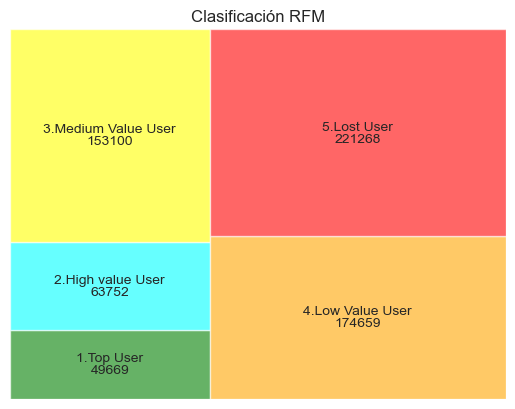

In [120]:
#Representación Gráfica
sns.set_style(style="whitegrid") # set seaborn plot style
sizes= users_class["user_id"].values # proportions of the categories
label=users_class["user_segment"]
squarify.plot(sizes=sizes, label=label,value=sizes, alpha=0.6,color=["green","cyan","yellow","orange","red"]).set(title='Clasificación RFM')
plt.axis('off')
plt.show()

Podemos obervar que gran parte de los clientes se encuentran catalogados como los peores usuarios, esto puede deberse a que solo tomamos el mes de Noviembre. Luego de esta clasificación lo interesante es observar como es la distribución de los clientes que hacen fraccionamiento transaccional en cada segmento.

In [121]:
# Distribución de los clientes con mala practica transaccional en cada segmento
df_fraude = df.groupby(by='user_id',as_index=False)['fraccionamiento_trx'].max()
rfm_fraude=rfm_df.merge(df_fraude,on='user_id')


users_class2=rfm_fraude[['fraccionamiento_trx','user_segment']].groupby(by=['user_segment']).sum().reset_index()

df_usuarios=users_class.merge(users_class2,on='user_segment')
df_usuarios['%fraccionamiento'] = [ round(df_usuarios['fraccionamiento_trx'].iloc[i]/df_usuarios['user_id'].iloc[i],2) if df_usuarios['user_id'].iloc[i]>0 else 0 for i in range(len(df_usuarios)) ]
df_usuarios

,user_segment,user_id,fraccionamiento_trx,%fraccionamiento
0,1.Top User,49669,12405,0.25
1,2.High value User,63752,8482,0.13
2,3.Medium Value User,153100,10373,0.07
3,4.Low Value User,174659,2291,0.01
4,5.Lost User,221268,2730,0.01


Podemos observar que la mayor parte de los clientes que realizan fraccionamiento transaccional se encuentran en los segmentos Top y High, esto es debido que, al realizar tantas transacciones el modelo RFM los cataloga como buenos clientes, por lo tanto, esta segmentación es una buena variable para el proceso de modelación a posteriori.

### Análisis Descriptivo:

In [122]:
#Construir base de datos para el análisis descriptivo y modelo posteriori
rf_df = df_recency.merge(frequency_df, on='user_id')
df_m = rf_df.merge(monetary_df, on='user_id').drop(columns='last_operation_date')
df_model= df_m.merge(rfm_fraude,on='user_id')
df_model=df_model[['fraccionamiento_trx','Recency','Frequency','Monetary','user_segment']]
df_model['fraccionamiento_trx']=df_model['fraccionamiento_trx'].astype('str')

In [123]:
# Crear variable Dummy para la variable cualitativa de segmentación construida con el RFM
user = pd.get_dummies(df_model['user_segment'])
df_model=df_model.drop(columns=['user_segment'])
df_model= pd.concat([df_model,user],axis=1)

In [124]:
df_model.head(5)

,fraccionamiento_trx,Recency,Frequency,Monetary,1.Top User,2.High value User,3.Medium Value User,4.Low Value User,5.Lost User
0,0,2,6,986.779532,1,0,0,0,0
1,1,7,2,47.555640,0,0,1,0,0
2,0,13,1,23.777820,0,0,0,0,1
3,0,14,1,475.556401,0,0,0,0,1
4,0,3,3,392.334031,0,1,0,0,0


Se realizó la transformación de la variable segmentación a Dummy, ya que algunos algoritmos de machine learning no permiten este tipo de codificación en su estructura.

**Análisis Gráfico**

In [125]:
distribucion = df_model[['fraccionamiento_trx','Recency']].groupby('fraccionamiento_trx').count().reset_index().rename(columns={"Recency": "Cantidad"})
distribucion

,fraccionamiento_trx,Cantidad
0,0,626167
1,1,36281


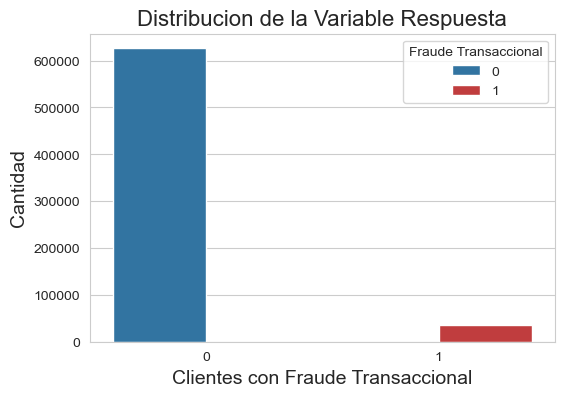

In [126]:
# Distribuciones de la variable objetivo
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='fraccionamiento_trx', y='Cantidad', data=distribucion, hue='fraccionamiento_trx', palette = ['#1F77B4', '#D62728'])

plt.title("Distribucion de la Variable Respuesta", fontsize=16)
plt.legend(title="Fraude Transaccional")
plt.xlabel('Clientes con Fraude Transaccional', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.show()

Podemos observar que la variable objetivo presenta un notorio desbalanceo, lo cual puede ser problemas en el proceso de modelación.

[Text(0.5, 1.0, 'Recencia por Fraccionamiento TRX')]

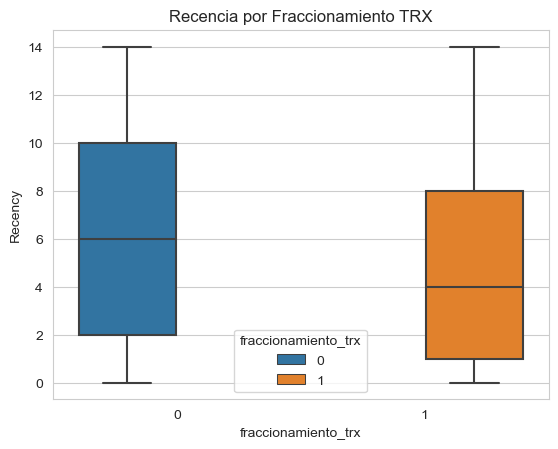

In [127]:
boxplot(x="fraccionamiento_trx", y="Recency", hue="fraccionamiento_trx", data=df_model).set(title = 'Recencia por Fraccionamiento TRX')

[Text(0.5, 1.0, 'Frecuencia por Fraccionamiento TRX')]

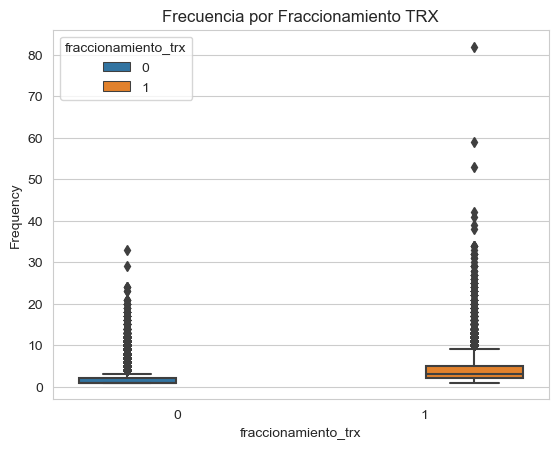

In [128]:
boxplot(x="fraccionamiento_trx", y="Frequency", hue="fraccionamiento_trx", data=df_model).set(title = 'Frecuencia por Fraccionamiento TRX')

[Text(0.5, 1.0, 'Monto por Fraccionamiento TRX')]

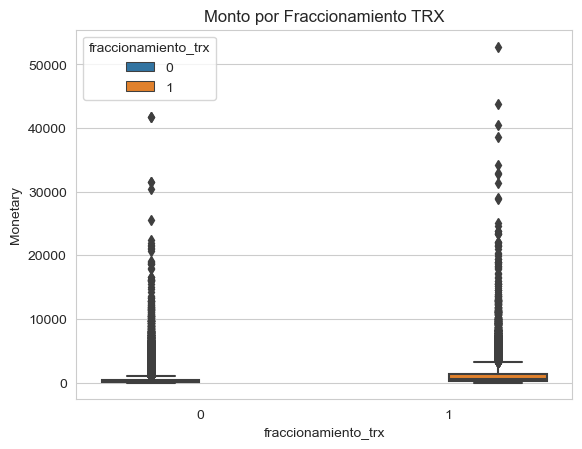

In [129]:
boxplot(x="fraccionamiento_trx", y="Monetary", hue="fraccionamiento_trx", data=df_model).set(title = 'Monto por Fraccionamiento TRX')

De los 3 gráfico de cajas podemos observar que existen diferencias significativas en el comportamiento de los clientes con fraccionamiento transaccional, catalogados como '1'.

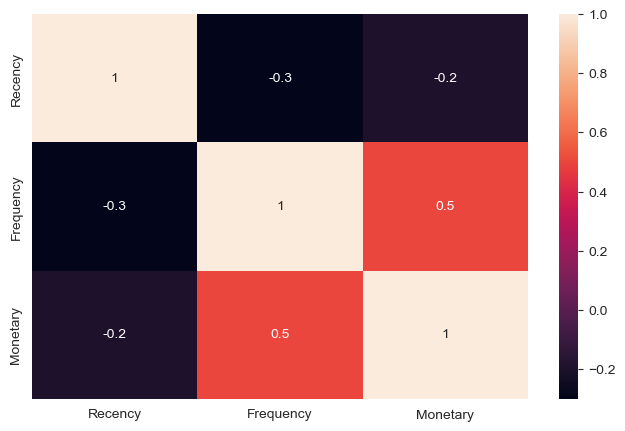

In [130]:
df_corr= df_model.drop(columns=['1.Top User','2.High value User','3.Medium Value User','4.Low Value User','5.Lost User'])
corr = df_corr.corr().round(1)
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True)
plt.show()

Con la matriz de correlación podemos observar que nuestras variables presentan cierta relación entre sí, siendo la más notoria la frecuencia y el monto.

# Paso 3: Modelos de Aprendizaje Supervisado
Se llevarán a cabo 3 modelos de aprendizaje supervisado, con el objetivo de predecir los clientes con malas practicas transaccionales.

## 1. Desarrollo de los modelos:
Para desarrollar las metodologias se tendrán la siguiente variable objetivo y predictivas:


**Y**= Cliente con fraccionamiento Transaccional (1=SI, 0=NO)

**X1**= Recencia

**X2**= Frecuencia

**X3**= Monto

**X4**= Cliente TOP (1=SI, 0=NO)

**X5**= Cliente HIGH (1=SI, 0=NO)

**X6**= Cliente MEDIUM (1=SI, 0=NO)

**X7**= Cliente LOW (1=SI, 0=NO)

**X8**= Cliente LOST (1=SI, 0=NO)

In [131]:
#División variable objetivo y variables predictivas
X = df_model.drop(columns=['fraccionamiento_trx'], axis=1)
y = df_model['fraccionamiento_trx']

In [132]:
#Balanceo undersampling
X_b = np.array(X)
y_b = y.ravel()
tl = RandomUnderSampler()
X_train_u, y_train_u = tl.fit_resample(X_b, y_b)
y = pd.DataFrame(y_train_u)
X = pd.DataFrame(X_train_u)

Se realiza un balanceo a nuestros datos, en este caso se eliminan datos de nuestra clase mayoritaria hasta alcanzar el número de la minoritaria. La base ahora cuenta con 92.108 clientes.

**Nota:** No es idoneo en la practica realizar este tipo de balanceo ya que puede afectar notoriamente con la distribución intrinseca de los datos, pero por motivos de recurso computacional se decir realizar esta tecnica de undersampling, logrando asi disminuir notoriamente la cantidad de registros de la base de datos y con esto, los algoritmos presentarán un tiempo de ejecución mucho menor.

In [133]:
#División en base de entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)

In [134]:
#Estandarizar variables predictivas cuantitativas
from sklearn.preprocessing import StandardScaler

#estandarizacion con StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

Se estandarizan las variables debido a que algunos métodos se basan en distancias, por lo cual es importante que las variables predictivas esten sobre la misma escala.

### Random Forest:
Random Forest es un método de aprendizaje Supervisado el cual es basado en arboles, especificamente es una generalización del árbol de decisión. Para este problema se utilizaran los parametros por defecto y no se realizará podado lo cual es lo mas recomendable en proyectos reales ya que ayuda con la generalización del modelo.

In [135]:
# metodo p veces K-Fold para el Random forest (p=5;k=5)
medias_tree=[]
for i in range(0,5):
  tree = RandomForestClassifier()
  # Entrenar el regresor - con los datos de entrenamiento
  tree.fit(X_train, y_train)
  # Dividimos los datos en 5 folders (K) para la validación k-folds
  kfold_tree = KFold(n_splits=5, random_state=i, shuffle=True)
  #Entrenamos el modelo con la validación cruzada K-fold con k=5)
  cv_scores_tree = cross_val_score(tree, X_train, y_train,cv=kfold_tree, scoring='accuracy')
  #Obtenemos nuestra matriz con las 10 iteraciones diferentes k-fold y las almacenamos en un array
  media=round(np.mean(cv_scores_tree),5)
  desv=round(np.std(cv_scores_tree),5)
  medias_tree.append([i+1,media,desv])

#Generamos una tabla con los resultados
tree_dataframe=pd.DataFrame(medias_tree,columns=['Iteración', 'Accuracy Promedio K-Fold','Desv'])
tree_dataframe

,Iteración,Accuracy Promedio K-Fold,Desv
0,1,0.76245,0.00340
1,2,0.76215,0.00247
2,3,0.76168,0.00509
3,4,0.76131,0.00236
4,5,0.76085,0.00314


Se realizó el método de clasificación de random forest con una validación cruzada (p veces 5-fold). Esto con el fin de ver el comportamiento de los datos ante diferentes bases de prueba y poder observar si el modelo presenta problemas de sobreajuste. En cuanto a los resultados podemos ver que la precisión es aproximadamente del 83%.

### KNN:
KNN es un clasificador de aprendizaje supervisado no paramétrico, que utiliza la proximidad para hacer clasificaciones o predicciones sobre la agrupación de un punto de datos individual. Para este estudio utilizaremos el hiperparemtro por defecto de python que es K=5, pero es recomendable en situaciones reales realizar una optimización de dicho hiperparametro.

In [136]:
# metodo p veces K-Fold para el KNN (p=5;k=5)
medias_knn=[]
for i in range(0,5):
  mod_knn =  KNeighborsClassifier()
  # Entrenar el regresor - con los datos de entrenamiento
  mod_knn.fit(X_train, y_train)
  # Dividimos los datos en 5 folders (K) para la validación k-folds
  kfold_knn = KFold(n_splits=5, random_state=i, shuffle=True)
  #Entrenamos el modelo con la validación cruzada K-fold con k=5)
  cv_scores_knn = cross_val_score(mod_knn, X_train, y_train,cv=kfold_knn, scoring='accuracy')
  #Obtenemos nuestra matriz con las 10 iteraciones diferentes k-fold y las almacenamos en un array
  media=round(np.mean(cv_scores_knn),5)
  desv=round(np.std(cv_scores_knn),5)
  medias_knn.append([i+1,media,desv])

#Generamos una tabla con los resultados
knn_dataframe=pd.DataFrame(medias_knn,columns=['Iteración', 'Accuracy Promedio K-Fold','Desv'])
knn_dataframe

,Iteración,Accuracy Promedio K-Fold,Desv
0,1,0.76705,0.00122
1,2,0.76851,0.00473
2,3,0.76707,0.00253
3,4,0.76739,0.00257
4,5,0.76753,0.00382


Se realizó el método de clasificación KNN con una validación cruzada (p veces 5-fold). Esto con el fin de ver el comportamiento de los datos ante diferentes bases de prueba y poder observar si el modelo presenta problemas de sobreajuste. En cuanto a los resultados podemos ver que la precisión es aproximadamente del 84%.

### Gaussian Naive Bayes:
Gaussian Naive Bayes es un algoritmo de clasificación probabilística basado en la aplicación del teorema de Bayes con fuertes suposiciones de independencia. En el contexto de la clasificación, la independencia se refiere a la idea de que la presencia de un valor de una característica no influye en la presencia de otro (a diferencia de la independencia en la teoría de la probabilidad).

In [137]:
# metodo p veces K-Fold para el Gaussian Naive Bayes (p=5;k=5)
medias_NB=[]
for i in range(0,5):
  mod_NB =  GaussianNB()
  # Entrenar el regresor - con los datos de entrenamiento
  mod_NB.fit(X_train, y_train)
  # Dividimos los datos en 5 folders (K) para la validación k-folds
  kfold_NB = KFold(n_splits=5, random_state=i, shuffle=True)
  #Entrenamos el modelo con la validación cruzada K-fold con k=5)
  cv_scores_NB = cross_val_score(mod_NB, X_train, y_train,cv=kfold_NB, scoring='accuracy')
  #Obtenemos nuestra matriz con las 10 iteraciones diferentes k-fold y las almacenamos en un array
  media=round(np.mean(cv_scores_NB),5)
  desv=round(np.std(cv_scores_NB),5)
  medias_NB.append([i+1,media,desv])

#Generamos una tabla con los resultados
NB_dataframe=pd.DataFrame(medias_NB,columns=['Iteración', 'Accuracy Promedio K-Fold','Desv'])
NB_dataframe

,Iteración,Accuracy Promedio K-Fold,Desv
0,1,0.73148,0.00224
1,2,0.73177,0.00499
2,3,0.73205,0.00345
3,4,0.73170,0.00327
4,5,0.73166,0.00193


Se realizó el método de clasificación KNN con una validación cruzada (p veces 5-fold). Esto con el fin de ver el comportamiento de los datos ante diferentes bases de prueba y poder observar si el modelo presenta problemas de sobreajuste. En cuanto a los resultados podemos ver que la precisión es aproximadamente del 72%.

**COMPARACIÓN MODELOS**

In [138]:
#Se ponen los indicadores de Accuracy y su Variación de las dos metodologias en un DataFrame
indicadores= [['Accuracy Medio',round(tree_dataframe['Accuracy Promedio K-Fold'].mean(),4),round(knn_dataframe['Accuracy Promedio K-Fold'].mean(),4),round(NB_dataframe['Accuracy Promedio K-Fold'].mean(),4)],
['Accuracy Variación',round(tree_dataframe['Desv'].mean(),4),round(knn_dataframe['Desv'].mean(),4),round(NB_dataframe['Desv'].mean(),4)]]

ind = pd.DataFrame(indicadores, columns = ['Medida Desempeño','Random Forest','K-NN','Naive Bayes'])
ind = ind.set_index('Medida Desempeño')
print(ind)

                    Random Forest    K-NN  Naive Bayes
Medida Desempeño                                      
Accuracy Medio             0.7617  0.7675       0.7317
Accuracy Variación         0.0033  0.0030       0.0032


Se puede observar que el modelo KNN es el que proporciona mejores resultados, esto puede deberse a que esta metodologia es muy fuerte cuando se tiene un dataset con pocas variables predictivas, como es el caso.

**PREDICCIÓN KNN CON LOS DATOS TEST**

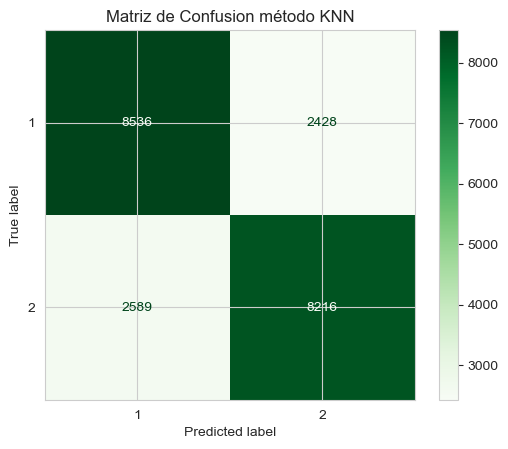

Metricas de desempeño del método de Clasificación Random Forest 
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     10964
           1       0.77      0.76      0.77     10805

    accuracy                           0.77     21769
   macro avg       0.77      0.77      0.77     21769
weighted avg       0.77      0.77      0.77     21769



In [139]:
# Predicción con los datos de test para la metodología con mejores resultados
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

y_pred_test = KNN.predict(X_test)
# Grafico de la matrix de confusion
fig = plot_confusion_matrix(KNN, X_test, y_test, display_labels=['1', '2'], cmap='Greens')
plt.title(f'Matriz de Confusion método KNN')
plt.show()

# Metricas de desempeño del modelo Final
print('Metricas de desempeño del método de Clasificación Random Forest ')
report = classification_report(y_test, y_pred_test)
print(report)

Observando la matriz de confusión y las metricas de desempeño, podemos concluir que el modelo para predecir los clientes con fraccionamiento es bastante correcto, ya que su accuracy es al rededor del 85%, siendo esta muy alta cuando de datos reales se tratan.

## 2. Actualización de los modelos (MLOps):
Una vez el modelo se encuentre en producción, se procede a utilizar la metodología MLOps, la cual ofrece una integración continua y una implementación rápida y repetible de modelos. Como tal, ayudan a las empresas a descubrir información e insights valiosos a partir de sus datos con mayor rapidez. Las MLOps también incluyen el monitoreo y la repetición del entrenamiento continuo de modelos en producción para garantizar que funcionen de manera óptima a medida que los datos cambian (evolucionan) con el tiempo. El tiempo en el que se debe actualizar el modelo va muy ligado a su comportamiento predictivo en ejecución, se puede implementar la estrategia de monitorearlo cada cierta periodicidad (podría ser cada 3 meses) y se debe medir su capacidad predictiva de las siguientes formas:


1. la primera consiste en establecer una métrica de desempeño que para este caso sería el accuracy y periódicamente revisar los resultados, esto con el fin de observar si el modelo presenta una decaída en su rendimiento y poder llevar a cabo posibles reentrenamientos o cambios de metodologías.
2. Otro método que considero más efectivo es comparar la distribución de los datos antes y después del despliegue. Dicha comparación se realiza con una prueba de hipótesis estadística para encontrar diferencias significativas.

Con la implementación de estos métodos se tendrá un modelo actualizado y se garantizará una capacidad predictiva similar a la obtenida en la fase de procesamiento.

## 3. Despliegue del Modelo:
Existen diferentes formas para llevar a cabo el despliegue del modelo. Una manera muy eficaz es utilizando Rest Api, la cual ayudará a tener el modelo desde un web service de una manera no tan compleja que otras alternativas. Para este caso se utilizarán los siguientes pasos:
1. Modelo procesado correctamente en Python.
2. Desplegar el modelo localmente, para esto utilizaremos Streamlit, la cual nos permitirá tener el modelo en la web de una manera sencilla y podemos realizar las pruebas necesarias.
3. Desplegar el modelo globalmente, para esto se puede utilizar Google Cloud, Heroku, Aws, Azure. En lo personal me gusta la alternativa de Heroku la cual es gratuita y muy intuitiva.

<img src="imagenes/pasos_despliegue.png" width="1000">

En esta prueba se llega al paso 2, en la cual se crea una pequeña aplicación local en Streamlit, la cual se puede ver desarrollada en el script "despliegue_modelo.py", a continuación adjunto una imagen del aplicativo:


<img src="imagenes/streamlit.png" width="1000">

Una vez ejecutados los pasos mencionados anteriormente podemos tener los modelos desplegados hacia los clientes y debemos ir almacenando los resultados para realizar el respectivo seguimiento al proyecto.

**Nota:** Para correr el aplicativo localmente se debe seguir estos pasos desde la terminal:
1. pip install Streamlit
2. streamlit run *despliegue_modelo.py*